# Proyecto 2 - Clasificación

## Laboratorio de Aprendizaje Estadístico

#### Fecha: 4 de Octubre 2025
### Integrantes:

|                |   |
:----------------|---|
| **Expediente**     | **Nombre**  |
| 742594 | Ana Sofía Hinojosa Bale  |
| 739208 | Julia Hernández Cardenas  |
| 750733 | Sara Hernández Ochoa  |

In [1]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

/Users/sofia/Desktop/séptimo/Proyecto2LabAprEstadistico/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Objetivos

## Generales

Desarrollar un modelo predictivo que clasifique transacciones financieras como fraudulentas o legítimas, maximizando la capacidad de detección de fraude a través de métricas de rendimiento como el ROC AUC, utilizando modelos de aprendizaje supervisado y optimización de hiperparámetros.

## Específicos

**1. Preprocesamiento de datos:**

Preprocesar los datos eliminando valores faltantes y columnas irrelevantes, convirtiendo variables categóricas en dummies y estandarizando las variables numéricas para que sean compatibles con los modelos.

**2. Implementación de Regresión Logística:**

Entrenar un modelo de Regresión Logística mediante validación cruzada para evaluar su desempeño y estabilidad en distintas particiones del dataset, y medir su capacidad de predicción de fraude.

**3. Implementación de SVM con kernel RBF:**

Entrenar un modelo de SVM, evaluando métricas como accuracy y ROC AUC, y analizar cómo el parámetro de regularización 
𝐶 afecta la capacidad de clasificación.

**4. Implementación de MLP (Perceptrón Multicapa):**

Entrenar un MLP con dos capas ocultas, ajustando el parámetro de regularización 
𝛼 y evaluando la capacidad del modelo para capturar relaciones no lineales en los datos.

**5. Optimización de hiperparámetros:**

Aplicar Optimización Bayesiana para encontrar la configuración óptima de los hiperparámetros de cada modelo (C para Regresión Logística y SVM, α para MLP) que maximice la ROC AUC.

**6. Comparación y selección del mejor modelo:**

Comparar los modelos entrenados utilizando métricas de desempeño, identificar cuál tiene mejor capacidad para detectar fraude, e interpretar los resultados para futuras mejoras, incluyendo balanceo de clases o ingeniería de variables.

# Marco Teórico


### 1. Regresión Logística
La Regresión Logística estima la probabilidad de que una transacción sea fraudulenta mediante la función sigmoide:

$$
P(y=1|x) = \frac{1}{1 + e^{-z}}, \quad z = \beta_0 + \sum_{i=1}^{n} \beta_i x_i
$$
Esta fórmula calcula la probabilidad de que una transacción sea fraudulenta transformando una combinación lineal de las variables predictoras.

Se entrena el modelo maximizando la verosimilitud:

$$
L(\beta) = \prod_{i=1}^{N} P(y_i|x_i)^{y_i} [1 - P(y_i|x_i)]^{1 - y_i}
$$
La verosimilitud mide qué tan bien los parámetros del modelo explican los datos observados.

La regularización L2 se aplica para evitar sobreajuste:

$$
J(\beta) = -\frac{1}{N}\sum_{i=1}^{N} \left[ y_i\log(\hat{y_i}) + (1-y_i)\log(1-\hat{y_i}) \right] + \frac{\lambda}{2}\|\beta\|^2
$$
Esta función combina el error de predicción con un término que penaliza coeficientes demasiado grandes.

---

### 2. Máquina de Soporte Vectorial (SVM)
SVM busca maximizar el margen entre clases mientras controla los errores:

$$
\min_{w,b} \frac{1}{2}\|w\|^2 + C \sum_{i=1}^{N} \xi_i
$$
Se minimiza la norma de los pesos (maximizando el margen) y se penalizan los errores con el parámetro \(C\).

sujeto a:

$$
y_i (w \cdot x_i + b) \geq 1 - \xi_i, \quad \xi_i \geq 0
$$
Estas restricciones aseguran que las transacciones sean clasificadas correctamente, permitiendo algunos errores si es necesario.

Se utiliza kernel RBF para transformar los datos a un espacio de mayor dimensionalidad:

$$
K(x_i, x_j) = \exp(-\gamma \|x_i - x_j\|^2)
$$
El kernel RBF permite que SVM encuentre fronteras de decisión no lineales entre transacciones legítimas y fraudulentas.

---

### 3. Perceptrón Multicapa (MLP)
MLP es un modelo que aprende relaciones no lineales entre las variables de entrada y la variable objetivo:

$$
h_j = f\left(\sum_{i} w_{ij} x_i + b_j\right), \quad f(x) = \max(0, x)
$$
Cada unidad calcula una combinación de las variables de entrada y aplica una función de activación para capturar relaciones complejas en los datos.

El entrenamiento minimiza la entropía cruzada:

$$
E = - \sum_{i=1}^{N} \left[ y_i \log(\hat{y_i}) + (1 - y_i)\log(1-\hat{y_i}) \right]
$$
Esta función mide qué tan bien el modelo predice las probabilidades correctas de fraude.

Con regularización L2:

$$
J(W) = E + \alpha \|W\|^2
$$
Se añade un término de penalización sobre los coeficientes para evitar sobreajuste en el modelo.

---

### 4. Optimización Bayesiana con Procesos Gaussianos (GPR)
Se usa para ajustar hiperparámetros de manera eficiente, modelando la función objetivo como un proceso gaussiano:

$$
f(x) \sim \mathcal{GP}(m(x), k(x, x'))
$$
Esto define una distribución sobre funciones posibles que se ajustan a los datos observados.

Kernel RBF:

$$
k(x, x') = \exp\left(-\frac{\|x - x'\|^2}{2l^2}\right)
$$
El kernel RBF determina la similitud entre configuraciones de hiperparámetros y controla la suavidad de la función estimada.

Se selecciona el siguiente punto a evaluar usando el Upper Confidence Bound (UCB):

$$
x_{\text{next}} = \arg\max \left( \mu(x) + 1.96 \cdot \sigma(x) \right)
$$
Se elige el siguiente hiperparámetro buscando un equilibrio entre exploración y explotación basado en la media y la incertidumbre de la predicción.


Desarrollar un modelo predictivo que clasifique transacciones financieras como fraudulentas o legítimas, maximizando la capacidad de detección de fraude a través de métricas de rendimiento como el ROC AUC, utilizando modelos de aprendizaje supervisado y optimización de hiperparámetros.

# Análisis del Dataset

**¿De dónde viene?**

El dataset fue descargado directamente desde la plataforma Kaggle mediante la librería kagglehub, la cual permite obtener datasets automáticamente en Python para análisis de datos y machine learning.

**¿Qué contiene?**

El dataset contiene información sobre transacciones con tarjeta de crédito, incluyendo tanto variables numéricas como categóricas. Entre las variables más relevantes se encuentran:
Amount: monto de la transacción

- Age: edad del titular de la tarjeta

- Merchant Group: tipo de comercio

- Type of Card: tipo de tarjeta utilizada

- Bank: banco emisor

- Gender: género del titular

- Country of Transaction: país donde se realizó la transacción

- Entry Mode: forma de entrada de la transacción (POS, Tap, PIN, etc.)

- Type of Transaction: POS, Online, etc.

- Day of Week: día de la semana

- Fraud: etiqueta que indica si la transacción es fraudulenta (True/False)

**¿Qué información dan las muestras?**

Cada registro representa una transacción individual. Las variables numéricas como Amount y Age permiten cuantificar la transacción y características del titular, mientras que las categóricas describen el contexto (tipo de tarjeta, banco, país, etc.). La variable objetivo Fraud indica si la transacción fue identificada como fraude, lo que convierte este dataset en un problema de clasificación binaria.

**¿Qué se quiere analizar?**

Se busca detectar transacciones fraudulentas mediante modelos de aprendizaje supervisado. El objetivo es identificar patrones que distingan transacciones legítimas de fraudulentas, optimizando la predicción mediante métricas como ROC AUC y accuracy.

**¿Qué variables se tienen que transformar para poder usarse en un modelo de regresión?**

Las variables categóricas (Merchant Group, Type of Card, Bank, Gender, Country of Transaction, Entry Mode, Type of Transaction) deben convertirse en variables dummy o one-hot encoding.

La variable Day of Week se transforma a valores numéricos (0 = Monday, 6 = Sunday) para poder usarse como predictor.

Las variables numéricas (Amount, Age) se deben escalar o estandarizar para que tengan media cero y desviación estándar uno, evitando que valores grandes dominen a los modelos.

**¿Qué transformaciones se van a usar?**

- Eliminación de columnas irrelevantes (Transaction ID, Date, Shipping Address, Country of Residence).

- Codificación de variables categóricas a dummies con drop_first=True para evitar multicolinealidad.

- Escalado de variables numéricas usando StandardScaler.

**¿Qué resultado se podría encontrar al realizar una regresión?**

Al aplicar modelos de clasificación como Regresión Logística, SVM o MLP sobre estas variables preprocesadas, se espera obtener:

- Probabilidades de que cada transacción sea fraudulenta.

- Métricas de desempeño que permitan evaluar la calidad del modelo, como ROC AUC, accuracy, precision y recall.

- Identificación de patrones relevantes en las variables predictoras que más influyen en la detección de fraude.

#### Descarga de datos 

In [2]:
path = kagglehub.dataset_download(
    "anurag629/credit-card-fraud-transaction-data")
print("Path to dataset files:", path)
os.listdir(path)

Path to dataset files: /Users/sofia/.cache/kagglehub/datasets/anurag629/credit-card-fraud-transaction-data/versions/1


['CreditCardData.csv']

In [3]:
df = pd.read_csv(os.path.join(path, "CreditCardData.csv"))
df = df.head(1000)

In [4]:
def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    data = data.dropna().reset_index(drop=True)
    data = data.drop(columns=['Transaction ID',
                              'Date',
                              'Shipping Address',
                              'Country of Residence'])
    data['Amount'] = data['Amount'].replace('£', '', regex=True).astype(float)
    data = pd.get_dummies(data, columns=['Merchant Group',
                                         'Type of Card',
                                         'Bank',
                                         'Gender',
                                         'Country of Transaction',
                                         'Entry Mode',
                                         'Type of Transaction'], drop_first=True)
    data['Day of Week'] = data['Day of Week'].map({
        'Monday': 0,
        'Tuesday': 1,
        'Wednesday': 2,
        'Thursday': 3,
        'Friday': 4,
        'Saturday': 5,
        'Sunday': 6
    })

    return data


def get_target(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    X = data.drop(columns=['Fraud'])
    y = data['Fraud']
    return X, y


def scaler(X: pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler()

    columns_to_scale = X.select_dtypes(include=['float64', 'int64']).columns
    X_scaled = X.copy()
    X_scaled[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

    return X_scaled


def regresion_logistica(X: pd.DataFrame, y: pd.Series, kfolds: KFold, C: float) -> tuple:
    pipeline = Pipeline(steps=[
        ('model', LogisticRegression(C=C, random_state=42, max_iter=1000))
    ])

    scoring_metrics = {
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc'
    }

    scores = cross_validate(
        estimator=pipeline,
        X=X,
        y=y,
        cv=kfolds,
        scoring=scoring_metrics,
        return_train_score=False
    )

    results = []
    results.append({
        'model': 'Logistic Regression',
        'accuracy_mean': scores['test_accuracy'].mean(),
        'accuracy_std': scores['test_accuracy'].std(),
        'roc_auc_mean': scores['test_roc_auc'].mean(),
        'roc_auc_std': scores['test_roc_auc'].std()
    })

    roc_auc_mean = scores['test_roc_auc'].mean()
    return roc_auc_mean, results


def sup_vector_machine(X: pd.DataFrame, y: pd.Series, kfolds: KFold, C: float) -> dict:
    pipeline = Pipeline(steps=[
        ('model', SVC(C=C, kernel='rbf', random_state=42, probability=True))
    ])

    scoring_metrics = {
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc'
    }

    scores = cross_validate(
        estimator=pipeline,
        X=X,
        y=y,
        cv=kfolds,
        scoring=scoring_metrics,
        return_train_score=False
    )
    results = []

    results.append({
        'model': 'Support Vector Machine',
        'accuracy_mean': scores['test_accuracy'].mean(),
        'accuracy_std': scores['test_accuracy'].std(),
        'roc_auc_mean': scores['test_roc_auc'].mean(),
        'roc_auc_std': scores['test_roc_auc'].std()
    })

    roc_auc_mean = scores['test_roc_auc'].mean()

    return roc_auc_mean, results


def mlp_classifier(X: pd.DataFrame, y: pd.Series, kfolds: KFold,
                   hidden_layer_sizes=(25, 17), activation='relu', solver='adam',
                   max_iter=200, random_state=42) -> tuple:
    pipeline = Pipeline(steps=[
        ('model', MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver=solver,
            max_iter=max_iter,
            random_state=random_state
        ))
    ])

    scoring_metrics = {
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc'
    }

    scores = cross_validate(
        estimator=pipeline,
        X=X,
        y=y,
        cv=kfolds,
        scoring=scoring_metrics,
        return_train_score=False
    )

    results = []
    results.append({
        'model': 'MLP Classifier',
        'accuracy_mean': scores['test_accuracy'].mean(),
        'accuracy_std': scores['test_accuracy'].std(),
        'roc_auc_mean': scores['test_roc_auc'].mean(),
        'roc_auc_std': scores['test_roc_auc'].std()
    })

    roc_auc_mean = scores['test_roc_auc'].mean()

    return roc_auc_mean, results

In [5]:
data = preprocess_data(df)
X, y = get_target(data)
X_scaled = scaler(X)
X_scaled

,Day of Week,Time,Amount,Age,Merchant Group_Electronics,Merchant Group_Entertainment,Merchant Group_Fashion,Merchant Group_Food,Merchant Group_Gaming,Merchant Group_Products,...,Bank_RBS,Gender_M,Country of Transaction_India,Country of Transaction_Russia,Country of Transaction_USA,Country of Transaction_United Kingdom,Entry Mode_PIN,Entry Mode_Tap,Type of Transaction_Online,Type of Transaction_POS
0,0.966509,0.824984,-0.816659,-2.056738,False,True,False,False,False,False,...,True,True,False,False,False,True,False,True,False,True
1,0.966509,0.462920,1.505351,0.403693,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,True
2,0.966509,-0.080177,-0.816659,-0.342503,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,True
3,-1.026416,-0.080177,-0.627944,0.544865,False,True,False,False,False,False,...,False,False,False,False,False,True,False,True,False,True
4,-1.026416,1.549112,-0.111030,-0.766020,True,False,False,False,False,False,...,False,True,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,0.966509,0.824984,-0.709994,-1.189537,True,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,False
994,0.966509,1.187048,0.922798,-1.028197,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
995,-1.026416,-0.623273,-0.792044,0.716289,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
996,0.966509,-1.347401,1.997650,0.141516,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False


# Regresión Logística

In [6]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

_, results = regresion_logistica(X_scaled, y, kfolds, C=1.0)
results

[{'model': 'Logistic Regression',
  'accuracy_mean': np.float64(0.9248484848484848),
  'accuracy_std': np.float64(0.020639900911629223),
  'roc_auc_mean': np.float64(0.8687345103615023),
  'roc_auc_std': np.float64(0.05296624532548086)}]

In [7]:
n_iter = 30
gaussian_x = np.random.uniform(-3, 3, size=(5, 1))
gaussian_y = []

for c_log in gaussian_x.flatten():
    C = 10 ** c_log
    auc, _ = regresion_logistica(X_scaled, y, kfolds, C)
    gaussian_y.append(auc)

gaussian_y = np.array(gaussian_y)

for i in range(n_iter):
    kernel = 1.0 * RBF(length_scale=1.0)
    gp = GPR(kernel=kernel, n_restarts_optimizer=5, random_state=42)
    gp.fit(gaussian_x, gaussian_y)

    x_candidates = np.random.uniform(-3, 3, size=(1000, 1))
    y_pred, y_std = gp.predict(x_candidates, return_std=True)

    y_upper = y_pred + 1.96 * y_std
    max_idx = np.argmax(y_upper)
    xn = x_candidates[max_idx, 0]

    C_new = 10 ** xn
    auc_new_lr, _ = regresion_logistica(X_scaled, y, kfolds, C_new)

    gaussian_x = np.vstack([gaussian_x, [[xn]]])
    gaussian_y = np.append(gaussian_y, auc_new_lr)

    print(f"Iter {i+1:02d} | C: {C_new:.5f} | ROC AUC={auc_new_lr:.4f}")

best_idx = np.argmax(gaussian_y)
best_log_c = gaussian_x[best_idx, 0]
best_c_lr = 10 ** best_log_c
best_score_lr = gaussian_y[best_idx]

print(f"Best C: {best_c_lr:.5f} with ROC AUC: {best_score_lr:.4f}")

Iter 01 | C: 1.28815 | ROC AUC=0.8696
Iter 02 | C: 1.19180 | ROC AUC=0.8691
Iter 03 | C: 95.84631 | ROC AUC=0.8664
Iter 04 | C: 992.34389 | ROC AUC=0.8664
Iter 05 | C: 0.04596 | ROC AUC=0.8452
Iter 06 | C: 0.00100 | ROC AUC=0.8056
Iter 07 | C: 0.00263 | ROC AUC=0.8075
Iter 08 | C: 598.85579 | ROC AUC=0.8665
Iter 09 | C: 2.14608 | ROC AUC=0.8684
Iter 10 | C: 992.44141 | ROC AUC=0.8664
Iter 11 | C: 0.10444 | ROC AUC=0.8564
Iter 12 | C: 8.52326 | ROC AUC=0.8681
Iter 13 | C: 43.30815 | ROC AUC=0.8671
Iter 14 | C: 0.00155 | ROC AUC=0.8068
Iter 15 | C: 805.95483 | ROC AUC=0.8664
Iter 16 | C: 1.45857 | ROC AUC=0.8698
Iter 17 | C: 1.43888 | ROC AUC=0.8697
Iter 18 | C: 1.44669 | ROC AUC=0.8698
Iter 19 | C: 1.44800 | ROC AUC=0.8698
Iter 20 | C: 1.45344 | ROC AUC=0.8698
Iter 21 | C: 1.46181 | ROC AUC=0.8696
Iter 22 | C: 2.91473 | ROC AUC=0.8692
Iter 23 | C: 4.68097 | ROC AUC=0.8681
Iter 24 | C: 0.13948 | ROC AUC=0.8610
Iter 25 | C: 10.80438 | ROC AUC=0.8682
Iter 26 | C: 0.00205 | ROC AUC=0.8071
I

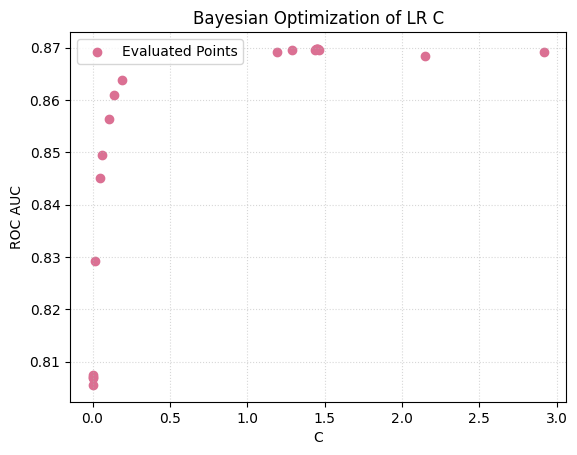

In [8]:
C_all = 10 ** gaussian_x.flatten()
mask = C_all <= 3
C_filtered = C_all[mask]
y_filtered = gaussian_y[mask]
plt.scatter(C_filtered, y_filtered, color='palevioletred', label='Evaluated Points')
plt.title('Bayesian Optimization of LR C')
plt.xlabel('C')
plt.ylabel('ROC AUC')
plt.grid(linestyle=':', alpha=0.5)
plt.legend()
plt.show()

# Máquina de soporte vectorial con kernel RBF

In [9]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

_, results_svc = sup_vector_machine(X_scaled, y, kfolds, C=1.0)
results_svc

[{'model': 'Support Vector Machine',
  'accuracy_mean': np.float64(0.9418989898989899),
  'accuracy_std': np.float64(0.022244791110684833),
  'roc_auc_mean': np.float64(0.8326351798282271),
  'roc_auc_std': np.float64(0.0775648334286751)}]

In [10]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

n_iter = 30

gaussian_x = np.random.uniform(-3, 3, size=(5, 1))
gaussian_y = []

for c_log in gaussian_x.flatten():
    C = 10 ** c_log
    auc, _ = sup_vector_machine(X_scaled, y, kfolds, C)
    gaussian_y.append(auc)

gaussian_y = np.array(gaussian_y)

for i in range(n_iter):
    kernel = 1.0 * RBF(length_scale=1.0)
    gp = GPR(kernel=kernel, n_restarts_optimizer=5, random_state=42)
    gp.fit(gaussian_x, gaussian_y)

    x_candidates = np.random.uniform(-3, 3, size=(1000, 1))
    y_pred, y_std = gp.predict(x_candidates, return_std=True)

    y_upper = y_pred + 1.96 * y_std
    max_idx = np.argmax(y_upper)
    xn = x_candidates[max_idx, 0]

    C_new = 10 ** xn
    auc_new_svc, _ = sup_vector_machine(X_scaled, y, kfolds, C_new)

    gaussian_x = np.vstack([gaussian_x, [[xn]]])
    gaussian_y = np.append(gaussian_y, auc_new_svc)

    print(f"Iter {i+1:02d} | C: {C_new:.5f} | ROC AUC={auc_new_svc:.4f}")

best_idx = np.argmax(gaussian_y)
best_log_c = gaussian_x[best_idx, 0]
best_c_svc = 10 ** best_log_c
best_score_svc = gaussian_y[best_idx]


print(f"Best C: {best_c_svc:.5f} with ROC AUC: {best_score_svc:.4f}")

Iter 01 | C: 13.38421 | ROC AUC=0.8506
Iter 02 | C: 8.92065 | ROC AUC=0.8545
Iter 03 | C: 978.23406 | ROC AUC=0.8374
Iter 04 | C: 3.10011 | ROC AUC=0.8514
Iter 05 | C: 450.50375 | ROC AUC=0.8374
Iter 06 | C: 5.94120 | ROC AUC=0.8497
Iter 07 | C: 0.47993 | ROC AUC=0.8281
Iter 08 | C: 31.01081 | ROC AUC=0.8386
Iter 09 | C: 0.54184 | ROC AUC=0.8278
Iter 10 | C: 161.13183 | ROC AUC=0.8374
Iter 11 | C: 515.65299 | ROC AUC=0.8374
Iter 12 | C: 161.10662 | ROC AUC=0.8374
Iter 13 | C: 0.00244 | ROC AUC=0.8263
Iter 14 | C: 0.01300 | ROC AUC=0.8273
Iter 15 | C: 1.55946 | ROC AUC=0.8389
Iter 16 | C: 0.05773 | ROC AUC=0.8280
Iter 17 | C: 9.80694 | ROC AUC=0.8529
Iter 18 | C: 0.00168 | ROC AUC=0.8184
Iter 19 | C: 0.08436 | ROC AUC=0.8285
Iter 20 | C: 22.27025 | ROC AUC=0.8422
Iter 21 | C: 60.56277 | ROC AUC=0.8374
Iter 22 | C: 0.00393 | ROC AUC=0.8235
Iter 23 | C: 2.14585 | ROC AUC=0.8451
Iter 24 | C: 0.23657 | ROC AUC=0.8282
Iter 25 | C: 0.03593 | ROC AUC=0.8281
Iter 26 | C: 789.44787 | ROC AUC=0.8

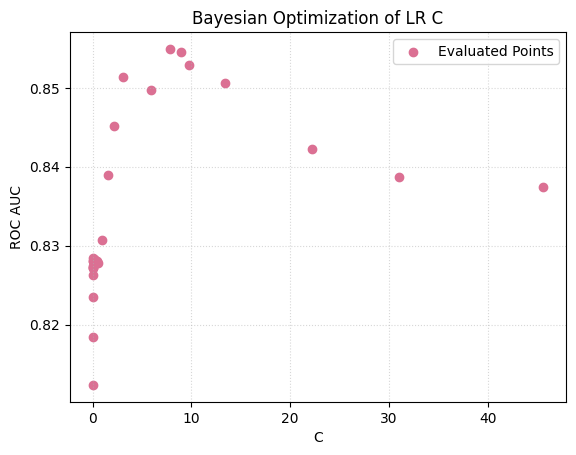

In [11]:
C_all = 10 ** gaussian_x.flatten()
mask = C_all <= 50
C_filtered = C_all[mask]
y_filtered = gaussian_y[mask]
plt.scatter(C_filtered, y_filtered, color='palevioletred', label='Evaluated Points')
plt.title('Bayesian Optimization of LR C')
plt.xlabel('C')
plt.ylabel('ROC AUC')
plt.grid(linestyle=':', alpha=0.5)
plt.legend()
plt.show()

# Multi-layer Perceptron

In [12]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

_, results_mlp = mlp_classifier(X_scaled, y, kfolds)
results_mlp

[{'model': 'MLP Classifier',
  'accuracy_mean': np.float64(0.9248383838383839),
  'accuracy_std': np.float64(0.029467693577874567),
  'roc_auc_mean': np.float64(0.8642479637730197),
  'roc_auc_std': np.float64(0.0509584611106095)}]

In [13]:
n_iter = 30
layer_range = (5, 50)  
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

gaussian_x = np.random.uniform(layer_range[0], layer_range[1], size=(5, 2))
gaussian_y = []

for h1, h2 in gaussian_x:
    auc_mean, _ = mlp_classifier(X, y, kfolds, hidden_layer_sizes=(int(h1), int(h2)))
    gaussian_y.append(auc_mean)

gaussian_y = np.array(gaussian_y)

for i in range(n_iter):
    kernel = 1.0 * RBF(length_scale=1.0)
    gp = GPR(kernel=kernel, n_restarts_optimizer=5, random_state=42)
    gp.fit(gaussian_x, gaussian_y)

    x_candidates = np.random.uniform(layer_range[0], layer_range[1], size=(1000, 2))
    y_pred, y_std = gp.predict(x_candidates, return_std=True)

    y_upper = y_pred + 1.96 * y_std
    y_lower = y_pred - 1.96 * y_std
    diff = y_upper - y_lower
    max_idx = np.argmax(diff)
    xn = x_candidates[max_idx]

    auc_new_mlp, _ = mlp_classifier(X, y, kfolds, hidden_layer_sizes=(int(xn[0]), int(xn[1])))

    gaussian_x = np.vstack([gaussian_x, [xn]])
    gaussian_y = np.append(gaussian_y, auc_new_mlp)

    print(f"Iter {i+1:02d} | Hidden Layers: ({int(xn[0])}, {int(xn[1])}) | ROC AUC={auc_new_mlp:.4f}")  

best_idx = np.argmax(gaussian_y)
best_layers = tuple(map(int, gaussian_x[best_idx]))
best_score_mlp = gaussian_y[best_idx]


print(f"\nBest hidden layers: {best_layers} | ROC AUC: {best_score_mlp:.4f}")

Iter 01 | Hidden Layers: (48, 6) | ROC AUC=0.6417
Iter 02 | Hidden Layers: (5, 49) | ROC AUC=0.8359
Iter 03 | Hidden Layers: (48, 48) | ROC AUC=0.8695
Iter 04 | Hidden Layers: (7, 5) | ROC AUC=0.8676
Iter 05 | Hidden Layers: (25, 49) | ROC AUC=0.8615
Iter 06 | Hidden Layers: (29, 5) | ROC AUC=0.8795
Iter 07 | Hidden Layers: (39, 17) | ROC AUC=0.8787
Iter 08 | Hidden Layers: (5, 38) | ROC AUC=0.8938
Iter 09 | Hidden Layers: (49, 18) | ROC AUC=0.8665
Iter 10 | Hidden Layers: (38, 49) | ROC AUC=0.8773
Iter 11 | Hidden Layers: (13, 45) | ROC AUC=0.8575
Iter 12 | Hidden Layers: (6, 13) | ROC AUC=0.8330
Iter 13 | Hidden Layers: (16, 5) | ROC AUC=0.8298
Iter 14 | Hidden Layers: (30, 22) | ROC AUC=0.8821
Iter 15 | Hidden Layers: (49, 40) | ROC AUC=0.8597
Iter 16 | Hidden Layers: (5, 28) | ROC AUC=0.8212
Iter 17 | Hidden Layers: (40, 5) | ROC AUC=0.8884
Iter 18 | Hidden Layers: (28, 43) | ROC AUC=0.8884
Iter 19 | Hidden Layers: (42, 40) | ROC AUC=0.8776
Iter 20 | Hidden Layers: (31, 11) | ROC A

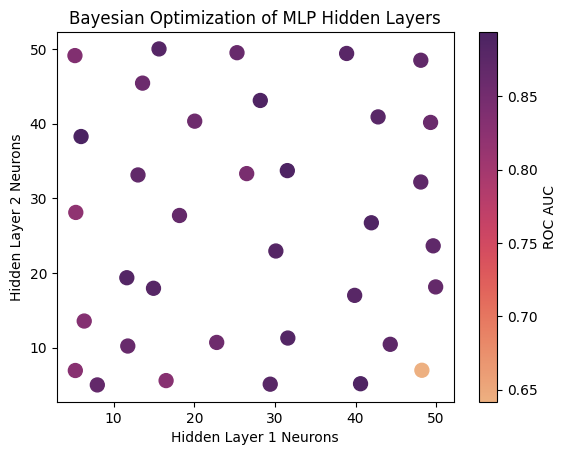

In [26]:
plt.scatter(gaussian_x[:, 0], gaussian_x[:, 1], c=gaussian_y, cmap='flare', s=100)
plt.colorbar(label='ROC AUC')
plt.xlabel('Hidden Layer 1 Neurons')
plt.ylabel('Hidden Layer 2 Neurons')
plt.title('Bayesian Optimization of MLP Hidden Layers')
plt.show()

In [15]:
comparison_df = pd.DataFrame(results + results_svc + results_mlp)
comparison_df

,model,accuracy_mean,accuracy_std,roc_auc_mean,roc_auc_std
0,Logistic Regression,0.924848,0.020640,0.868735,0.052966
1,Support Vector Machine,0.941899,0.022245,0.832635,0.077565
2,MLP Classifier,0.924838,0.029468,0.864248,0.050958


In [16]:
optim_comparison_df = pd.DataFrame({
    "ROC AUC": [best_score_lr, best_score_svc, best_score_mlp]
}, index=["Logistic Regression", "Support Vector Machine", "MLP Classifier"])

optim_comparison_df

,ROC AUC
Logistic Regression,0.869778
Support Vector Machine,0.854923
MLP Classifier,0.893824
